In [1]:
# run this same experiment again but instead of 2,0,0 -> 0,0,2 have 2,0,0 -> 0,1,1 this would be cool 
# declaring all dependancies    
import qutip as qt
import numpy as np
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.mode import QubitMode, SNAILMode, CavityMode
from quantum_logical.pulsesim.build_hamiltonian import Build_hamiltonian
import matplotlib.pyplot as plt
from quantum_logical.channel import AmplitudeDamping, PhaseDamping
from quantum_logical.trotter import TrotterGroup
from qutip import Options
from tqdm import tqdm_notebook as tqdm
from progressbar import progressbar
from threading import Thread
from multiprocessing.pool import Pool, ThreadPool
from numpy.linalg import eig

# opts = Options(nsteps=1e6, atol=1e-8, rtol=1e-6)
# p_bar = qt.ui.TextProgressBar()  # None
opts = {"nsteps": 1e6, "atol": 1e-8, "rtol": 1e-6, "progress_bar": "text"}

In [2]:
# adding all of the necessary elements to the full creation of the system 
# doing this with a qubit first 
qubit_dim = 2

# frequencies 
w1_un = 4
w2_un = 6
w3_un = 4.6666666666666666
ws_un = 5.6666666666666666

# coupling strength coefficient 
g1s = 2 * np.pi * 0.05467
g2s = 2 * np.pi * 0.0435
g3s = 2 * np.pi * 0.04875

# create array of the coefficients should be useful 
gs = [g1s, g2s, g3s]

# unknown value as of now 
g3 = .1

alpha = [.1, .1, .1]
g13 = g23 = g12 = .01

In [3]:
# creating the qubits and the hilbert space
qubit1 = QubitMode(
    mode_type="Qubit", name="q1", dim=qubit_dim, freq=w1_un, alpha=-0.161, T1=1e2, T2=5e1
)
qubit2 = QubitMode(
    mode_type="Qubit", name="q2", dim=qubit_dim, freq=w2_un, alpha=-0.1275, T1=1e2, T2=5e1
)
qubit3 = QubitMode(
    mode_type="Qubit", name="q3", dim=qubit_dim, freq=w3_un, alpha=-0.160, T1=1e2, T2=5e1
)
qubits = [qubit1, qubit2, qubit3]
snail = SNAILMode(mode_type="Snail", name="s", freq=ws_un, g3=0.3, dim=10, T1=1e3, T2=5e2)
_couplings = {
    frozenset([qubit1, snail]): 2 * np.pi * 0.05467,
    frozenset([qubit2, snail]): 2 * np.pi * 0.0435,
    frozenset([qubit3, snail]): 2 * np.pi * 0.04875
}

qs = QuantumSystem(qubits + [snail], couplings=_couplings)

system = []
system.extend(qubits)
system.extend([snail])

freq_list  = [qubit1.freq / (2 * np.pi), qubit2.freq / (2 * np.pi), qubit3.freq / (2 * np.pi), snail.freq / (2 * np.pi)] 
gqq = [[qubit1.freq,g12,g13],[g12,qubit2.freq,g23],[g13,g23,qubit3.freq]]

Will have to build the iswap using the 3-wave-mixing stuff.
Will have to build the controlled Z using sqrtiswaps and that is when the hamiltonian comes into effect.
Although we have three qubits labeled above the ancillas are a part of the three

In [4]:
# create the initial states of the qutrits
# physical qubits 
q = 1 # number of physical qubits 
qubit1_state = qt.basis(qubit_dim, 1) #+ qt.basis(qubit_dim, 1)  creating the encoded state with g and f 
qubit1_state /= qubit1_state.norm()

initial_encoded_state = qubit1_state
# prepare the ancillas in their respective states
# the qubit that i care about is the first one
for _ in range(2*q):
    initial_encoded_state = qt.tensor(initial_encoded_state, qt.basis(qubit_dim,0))
    initial_encoded_state /= initial_encoded_state.norm()
initial_encoded_state = qt.tensor(initial_encoded_state, qt.basis(snail.dim))
psi0 = initial_encoded_state 

In [5]:
# final state
# try mesolve but it may be easier to build the unitary 
psif = qt.tensor(qt.basis(qubit_dim, 1), qt.basis(qubit_dim,1), qt.basis(qubit_dim, 0) - qt.basis(qubit_dim, 1)).unit()

In [6]:
# # creating the eigenstates of the hamiltonian 
# H_no_time_calc = np.array(H_no_time)
# eigenvectors = H_no_time.eigenstates()
# # for i in eigenvectors:
# #     print(i @ initial_encoded_state)
# eigenvectors[0].shape


In [8]:
# creating a loss channel that will run during the gate 
trotter_dt = 0.05
amp_damp_channel = AmplitudeDamping(T1 = 1e2, num_qubits=3, hilbert_space_dim=qubit_dim)
phase_damp_channel = PhaseDamping(T1 = 1e2, T2 = 5e1, num_qubits=3, hilbert_space_dim=qubit_dim)
trotter = TrotterGroup(
    continuous_operators=[amp_damp_channel, phase_damp_channel],
    trotter_dt=trotter_dt,
)

TypeError: must be real number, not Qobj

In [9]:
# create decay channels that will run at all times 

In [10]:
# iswap out of 3-wave

In [11]:
# evolve the system and keep track of the times 
# build a time frame for checking if an error occured 

In [12]:
# why is it so bouncy? prepare it in the eigenstate of the hamiltonian and see 
# me_result = qt.mesolve(H=H_no_time, rho0=psi0, tlist=tlist, options=opts, progress_bar=True)
# fig, ax = plt.subplots()
# ax.plot(tlist, np.real(qt.expect(qs.modes_num[qubit2],me_result.states)))
# ax.plot(tlist, np.real(qt.expect(qs.modes_num[qubit1],me_result.states)))
# ax.plot(tlist, np.real(qt.expect(qs.modes_num[qubit3],me_result.states)))

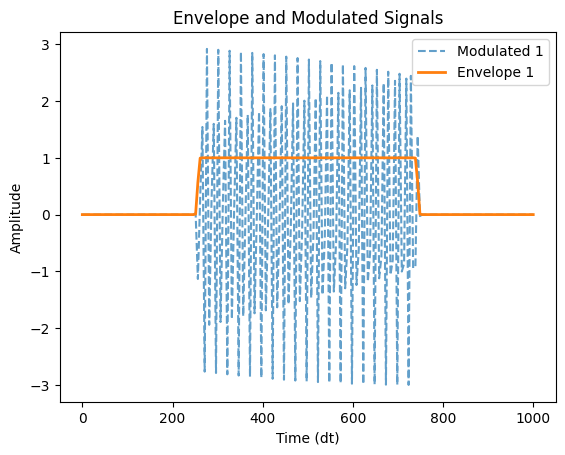

In [13]:
# build the CZ gate 
# creating the pulse and the hamiltonian pulse term
H_pump = qs.modes_a_dag[snail] + qs.modes_a[snail]
args = {"shape": Pulse.smoothbox, "shape_params": {"t0": 250, "width": 500}}
pulse = Pulse(omega=3, amp=3)
Pulse.plot_pulse([(pulse, args)], tlist)


In [14]:
# building the CZ gate
# do the same thing that you would normally do for the iswap and see if you can get something that can make sense and if so then maybe this works but who knows at this point 
# might have to try gate decomp so look into that 
# optimize over the pulse to get the state that you want 
freqs = np.linspace(0, 2, 2)
amps = np.linspace(0, 4, 2)
amps_freqs_tuple = [(i,j) for i in amps for j in freqs]

def sim_task(amps_freqs_tuple):
    amp, freq = amps_freqs_tuple

    pulse = Pulse(omega=freq, amp=amp)
    args = {"shape": Pulse.smoothbox, "shape_params": {"t0": 10, "width": 80}}
    H_total = [H_no_time, [H_pump, pulse.drive]]

    result = qt.mesolve(H=H_total, rho0=initial_encoded_state, tlist=tlist, options= opts, progress_bar = True, args=args)

    fid = qt.fidelity(qt.ptrace(result.states[-1], [0,1,2]), psif)

    return (amp, freq, fid)


In [15]:
# results = qt.parallel.parallel_map(sim_task, amps_freqs_tuple, progress_bar=True)
# use this to actually find the state and you would have to do this over all of the states that is why this might be easier if you build the operator and it over a multitude of states 

In [19]:
# try this with the propagator and breaking the state down into its constiuent parts 
# this might involve decomposition first which I will continue to read
# create arbitrary states and then have the gate acting on it and build the proper unitary 
H_total = [H_no_time, [H_pump, pulse.drive]]
res = qt.propagator(H = H_total, t = tlist, args = args, options = opts)
# will have to run this in a way as to optimize over the unitary in order to actually find the one that actually does the job 
# this will be somewhat complex but there has to be a decomp way of doing this faster so look into that if you want to be more efficient 

117649

In [ ]:
# within this have a list of states that it has to convert properly and then that is the gate that you are trying to build so this is not hard at all
# build all of the states that it has to chech against 
# creating the arbitrary state based on the decomp of untensored qubit states
qubit1_states = [(a * qt.basis(qubit_dim, 0) + b * qt.basis(qubit_dim, 1)) for a in range(7) for b in range(7)]
qubit2_states = [(a * qt.basis(qubit_dim, 0) + b * qt.basis(qubit_dim, 1)) for a in range(7) for b in range(7)]
qubit3_states = [(a * qt.basis(qubit_dim, 0) + b * qt.basis(qubit_dim, 1)) for a in range(7) for b in range(7)]
psi0_state  = [qt.tensor(i, j, k, qt.basis(snail.dim)) for i in qubit1_states for j in qubit2_states for k in qubit3_states] # these are all of the initial states of the system

In [ ]:
# run the propagator task for finding the control z operator (not state dependant like the mesolve method is)

In [17]:
# implement the CZ gate